In [2]:
import os
import json
from datetime import datetime
from typing import Iterable, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    silhouette_score,
)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from meteostat import Hourly, Point

import geopandas as gpd
import contextily as ctx

%matplotlib inline


---
# DATA

In [3]:
TRIPS_CSV = "Trips_2018.csv"
TRIPS_CSV_PROXY = "Trips_2018_short.csv"
PROXY_USAGE = False

#df = pd.read_csv("Trips_2018.csv")
#short_df = df.head(1000)
#short_df.to_csv("Trips_2018_short.csv", index=False)


df_path = TRIPS_CSV_PROXY if PROXY_USAGE else TRIPS_CSV
df = pd.read_csv(df_path)
df.drop('Unnamed: 0', axis=1, inplace=True)

print(df.shape)
df.head()

(17548339, 13)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


---
# PREPROCESS - TASK 1

## STATIONS - TASK 1

In [4]:
#COLLECT STATIONS
print("Unique starting st ids:", len(df['start_station_id'].unique()))
print("Unique ending st ids:", len(df['end_station_id'].unique()))

print("Unique starting st coords:", len(df[["start_station_latitude", "start_station_longitude"]].drop_duplicates()))
print("Unique ending st coords:", len(df[["end_station_latitude", "end_station_longitude"]].drop_duplicates()))

Unique starting st ids: 819
Unique ending st ids: 851
Unique starting st coords: 919
Unique ending st coords: 954


In [5]:

def collect_stations(df) -> pd.DataFrame:
    # Collect unique stations by coordinates (not by station id) and assign new IDs.
    # Uses existing `df` DataFrame.

    # extract unique start and end coordinates and unify them
    start_coords = df[['start_station_latitude', 'start_station_longitude']].dropna()
    start_coords.columns = ['latitude', 'longitude']
    end_coords = df[['end_station_latitude', 'end_station_longitude']].dropna()
    end_coords.columns = ['latitude', 'longitude']

    stations = pd.concat([start_coords, end_coords], ignore_index=True).drop_duplicates().reset_index(drop=True)

    # assign new station ids
    stations['station_uid'] = range(0, len(stations))  
    stations = stations[['station_uid', 'latitude', 'longitude']]

    print("Number of unique stations (by coordinates):", len(stations))
    print(stations.head())
    return stations

stations = collect_stations(df)

Number of unique stations (by coordinates): 957
   station_uid   latitude  longitude
0            0  40.767272 -73.993929
1            1  40.719116 -74.006667
2            2  40.711174 -74.000165
3            3  40.683826 -73.976323
4            4  40.696089 -73.978034


---
### CLUSTERING - TASK 1

In [6]:

def evaluate_station_clustering(
    stations: pd.DataFrame,
    feature_cols: Iterable[str] = ("latitude", "longitude"),
    cluster_col: str = "cluster",
    drop_noise: bool = True,
    noise_labels: Union[int, str, Iterable] = (-1, "-1"),
    treat_na_as_noise: bool = True
):
    """
    Evaluate clustering quality for station coordinates (distortion & silhouette),
    and report how many noise points were collected.

    Compatible with your DBSCAN & KMeans outputs:
      - DBSCAN: noise usually -1 (if kept)
      - KMeans: small clusters may be set to -1 or NaN depending on mark_noise
    """
    df = stations.copy()

    # Build noise mask

    labels_ser = df[cluster_col]
    mask_noise = labels_ser.isin(noise_labels)
    if treat_na_as_noise:
        mask_noise |= labels_ser.isna()

    n_noise = int(mask_noise.sum())
    n_total = int(len(df))

    # Optionally drop noise from evaluation set
    if drop_noise:
        df = df.loc[~mask_noise].copy()

   
    X = df.loc[:, feature_cols].to_numpy()
    labels = df[cluster_col].to_numpy()

    # Filter any lingering NaNs (shouldn't happen if treat_na_as_noise=True & drop_noise=True)
    valid = ~pd.isna(labels)
    X = X[valid]
    labels = labels[valid]

    unique = np.unique(labels)

    # Distortion (SSE) via centroids
    sse_total = 0.0
    for c in unique:
        Xi = X[labels == c]
        ctr = Xi.mean(axis=0)
        sse_c = float(((Xi - ctr) ** 2).sum())
        sse_total += sse_c

    sil = float(silhouette_score(X, labels, metric="euclidean"))

    return {
        "n_points": int(X.shape[0]),                 # evaluated (after dropping noise if drop_noise=True)
        "n_points_total": n_total,                   # total before dropping
        "n_noise": n_noise,                          # number of noise points collected
        "n_clusters": int(len(unique)),
        "distortion_sse": float(sse_total),
        "distortion_per_point": float(sse_total / max(1, X.shape[0])),
        "silhouette": sil,
    }, df

def plot_clusters(stations: pd.DataFrame, plot_name: str = "Station Clusters", cluster_col: str = "cluster"):
    plt.figure(figsize=(10, 8))
    unique_clusters = stations[cluster_col].dropna().unique()
    for cluster in unique_clusters:
        cluster_data = stations[stations[cluster_col] == cluster]
        plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', alpha=0.6)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(plot_name)
    plt.legend()
    plt.show()


In [7]:

def cluster_stations_dbscan(stations: pd.DataFrame, eps=0.0037, min_samples=4, mark_noise=False) -> pd.DataFrame:
    df = stations.copy()
    
    # Prepare coordinates for DBSCAN
    X = df[['latitude', 'longitude']].values

    # DBSCAN parameters: eps is in degrees, min_samples is minimum cluster size
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(X)

    if not mark_noise:
        # Optionally mark noise points (cluster = -1) as NaN
        df = df[df['cluster'] != -1].reset_index(drop=True)
    
    return df


def cluster_stations_kmeans(stations: pd.DataFrame, K:int, min_samples:int = 0, mark_noise=False) -> pd.DataFrame:
    df = stations.copy()
    # Prepare the coordinates for clustering
    X = df[['latitude', 'longitude']].values

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=K, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    if min_samples > 0:
            
        # add cluster sizes for kmeans clusters
        df['cluster_n'] = df.groupby('cluster')['cluster'].transform('count')
        low_count_clusters = df.loc[df['cluster_n'] < min_samples, 'cluster'].unique()

        # Mark these clusters as dropped (-1)
        df.loc[df['cluster'].isin(low_count_clusters), 'cluster'] = pd.NA if mark_noise else -1

        if not mark_noise:
            df = df[df['cluster'] != -1].reset_index(drop=True)

        df.drop('cluster_n', axis=1, inplace=True, errors='ignore')

    return df

{'n_points': 836, 'n_points_total': 957, 'n_noise': 121, 'n_clusters': 23, 'distortion_sse': 0.21036046747684092, 'distortion_per_point': 0.0002516273534411973, 'silhouette': 0.2518379541755772}


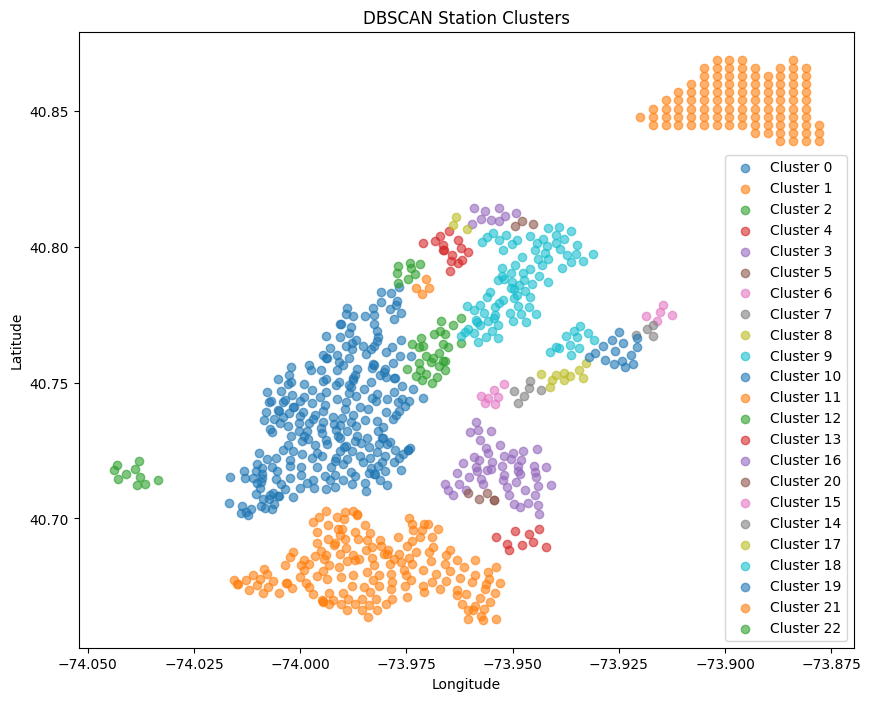

{'n_points': 955, 'n_points_total': 957, 'n_noise': 2, 'n_clusters': 21, 'distortion_sse': 0.09403009087362307, 'distortion_per_point': 9.846082813991945e-05, 'silhouette': 0.43697479628403163}


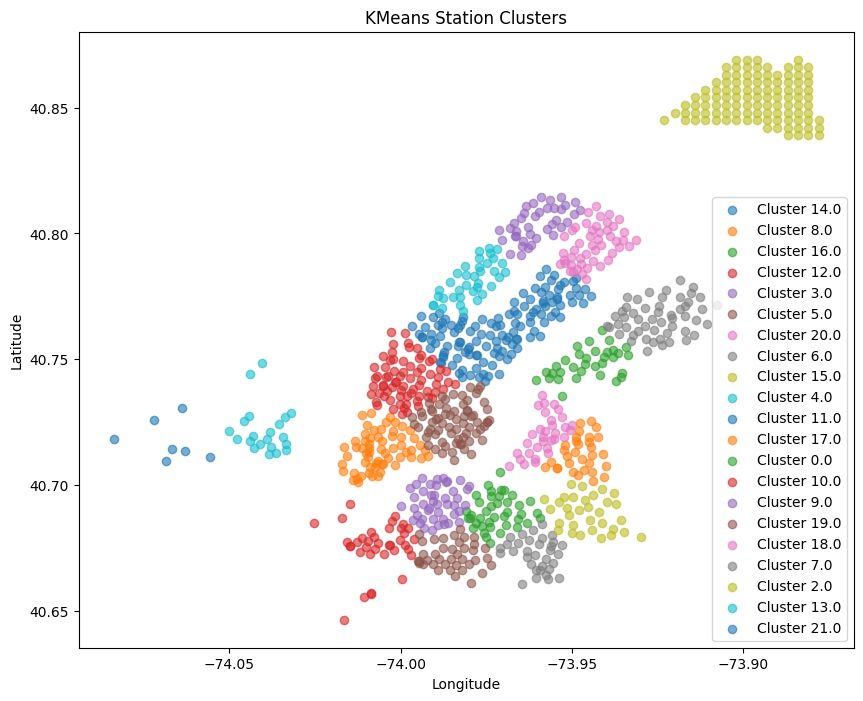

In [8]:
clustered_stations_dbscan = cluster_stations_dbscan(stations, eps=0.0037, min_samples=4, mark_noise=True)
eval_dbscan_stat, clustered_stations_dbscan = evaluate_station_clustering(clustered_stations_dbscan, drop_noise=True)
print(eval_dbscan_stat)
plot_clusters(clustered_stations_dbscan, "DBSCAN Station Clusters")

clustered_stations_kmeans = cluster_stations_kmeans(stations, K=22, min_samples=3, mark_noise=True)
eval_kmeans_stat, clustered_stations_kmeans = evaluate_station_clustering(clustered_stations_kmeans, drop_noise=True)
print(eval_kmeans_stat)
plot_clusters(clustered_stations_kmeans, "KMeans Station Clusters")

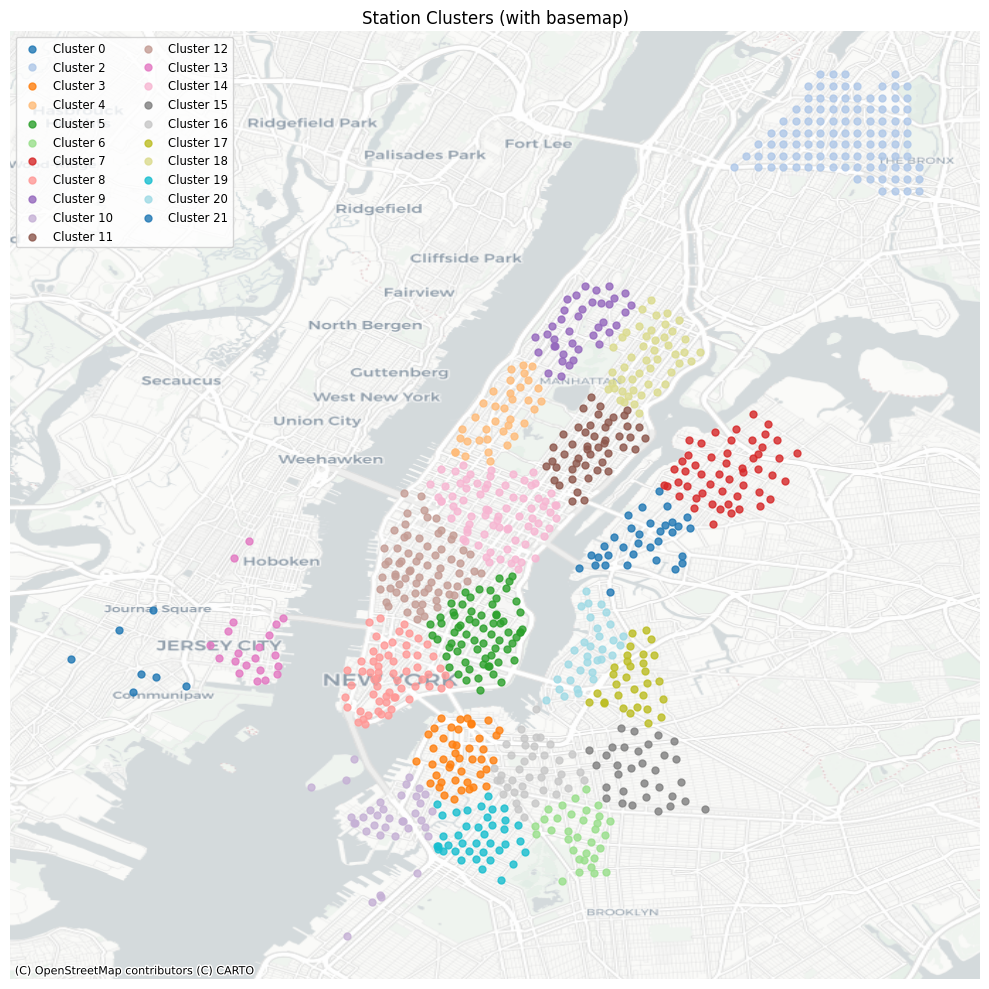

In [9]:

def plot_clusters_on_map(
    stations: pd.DataFrame,
    cluster_col: str = "cluster",
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    provider=None,
    figsize=(10, 10),
    alpha=0.8
):
    df = stations.copy()

    # GeoDataFrames (WGS84 -> Web Mercator)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326",
    ).to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=figsize)

    # scatter per cluster
    if len(gdf):
        clusters = df[cluster_col].dropna().unique().tolist()
        # sort numeric-like labels nicely
        def _key(x):
            try:
                fx = float(x); return (0, fx)
            except Exception:
                return (1, str(x))
        clusters = sorted(clusters, key=_key)

        cmap = plt.cm.tab20
        for i, c in enumerate(clusters):
            sub = gdf[gdf[cluster_col] == c]
            ax.scatter(sub.geometry.x, sub.geometry.y,
                       s=25, color=cmap(i % 20), alpha=alpha,
                       label=f"Cluster {int(c) if str(c).replace('.0','').isdigit() else c}")

        # bounds + small padding
        x0, y0, x1, y1 = gdf.total_bounds
        pad = max((x1 - x0), (y1 - y0)) * 0.05
        ax.set_xlim(x0 - pad, x1 + pad)
        ax.set_ylim(y0 - pad, y1 + pad)

    # add basemap
    if provider is None:
        provider = ctx.providers.CartoDB.Positron
    ctx.add_basemap(ax, source=provider, crs="EPSG:3857")
    ax.set_axis_off()
    ax.legend(loc="upper left", ncol=2, fontsize="small", frameon=True)
    ax.set_title("Station Clusters (with basemap)")
    plt.tight_layout()
    plt.show()

plot_clusters_on_map(clustered_stations_kmeans)  # assumes columns: latitude, longitude, cluster


In [10]:
def map_trips_to_station_clusters(df: pd.DataFrame, clustered_stations: pd.DataFrame, ) -> pd.DataFrame:
    df_mapped = df.copy()

    # create a mapping from coordinate tuple -> station_uid and add uid columns to trips df
    coord_to_cluster = { (row.latitude, row.longitude): row.cluster for row in clustered_stations.itertuples() }

    # vectorized creation of coordinate tuples and mapping
    df_mapped['start_coord'] = list(zip(df_mapped['start_station_latitude'], df_mapped['start_station_longitude']))
    df_mapped['end_coord'] = list(zip(df_mapped['end_station_latitude'], df_mapped['end_station_longitude']))

    df_mapped['start_cluster'] = df_mapped['start_coord'].map(coord_to_cluster)
    df_mapped['end_cluster'] = df_mapped['end_coord'].map(coord_to_cluster)

    # cleanup temporary columns if you don't want to keep them
    df_mapped.drop(columns=['start_station_id', 'end_station_id', 'start_coord', 'end_coord', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], inplace=True)

    return df_mapped

df_dbscan_clustered = map_trips_to_station_clusters(df, clustered_stations_dbscan)
df_kmeans_clustered = map_trips_to_station_clusters(df, clustered_stations_kmeans)

In [11]:
df_kmeans_clustered

,tripduration,starttime,stoptime,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,31956,Subscriber,1992,1,14.0,14.0
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,32536,Subscriber,1969,1,14.0,12.0
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,16069,Subscriber,1956,1,14.0,12.0
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,31781,Subscriber,1974,1,14.0,14.0
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,30319,Subscriber,1992,1,14.0,4.0
...,...,...,...,...,...,...,...,...,...
17548334,734,2018-12-31 23:55:06.9910,2019-01-01 00:07:21.2300,27111,Subscriber,1986,1,12.0,12.0
17548335,2551,2018-12-31 23:55:44.3070,2019-01-01 00:38:15.7820,16390,Customer,1969,0,9.0,14.0
17548336,2376,2018-12-31 23:56:52.8500,2019-01-01 00:36:29.2860,34398,Subscriber,1979,1,8.0,8.0
17548337,2758,2018-12-31 23:58:29.2120,2019-01-01 00:44:27.5170,30818,Customer,1969,0,9.0,14.0


In [12]:
def evaluate_clustering(df: pd.DataFrame):
    total_trips = len(df)
    mapped_trips = df.dropna(subset=['start_cluster', 'end_cluster'])
    num_mapped_trips = len(mapped_trips)
    mapping_rate = num_mapped_trips / total_trips * 100

    print(f"Total trips: {total_trips}")
    print(f"Mapped trips: {num_mapped_trips}")
    print(f"Mapping rate: {mapping_rate:.2f}%")

print("\nDBSCAN Clustered Trips Evaluation:")
evaluate_clustering(df_dbscan_clustered)

df_dbscan_clustered.dropna(subset=['start_cluster', 'end_cluster'], inplace=True)

print("\nKMeans Clustered Trips Evaluation:")
evaluate_clustering(df_kmeans_clustered)

df_kmeans_clustered.dropna(subset=['start_cluster', 'end_cluster'], inplace=True)



DBSCAN Clustered Trips Evaluation:
Total trips: 17548339
Mapped trips: 15169112
Mapping rate: 86.44%

KMeans Clustered Trips Evaluation:
Total trips: 17548339
Mapped trips: 17548257
Mapping rate: 100.00%


In [13]:
df_kmeans_clustered.head()

,tripduration,starttime,stoptime,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,31956,Subscriber,1992,1,14.0,14.0
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,32536,Subscriber,1969,1,14.0,12.0
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,16069,Subscriber,1956,1,14.0,12.0
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,31781,Subscriber,1974,1,14.0,14.0
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,30319,Subscriber,1992,1,14.0,4.0


---
## DATE TIME

In [14]:
def validate_tripduration(df: pd.DataFrame) -> None:
    # validate tripduration vs stoptime - starttime
    # convert to datetime if needed
    if df['starttime'].dtype == object:
        df['starttime'] = pd.to_datetime(df['starttime'])
    if df['stoptime'].dtype == object:
        df['stoptime'] = pd.to_datetime(df['stoptime'])

    # compute durations (seconds)
    #df['computed_duration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
    computed_duration = (df['stoptime'] - df['starttime']).dt.total_seconds()


    # summary comparisons
    n_total = len(df)
    n_exact = (df['tripduration'] == computed_duration).sum()
    n_rounded = (df['tripduration'] == computed_duration.round()).sum()
    n_within1 = (df['tripduration'] - computed_duration).abs().le(1).sum()
    n_diff_gt1 = (df['tripduration'] - computed_duration).abs().gt(1).sum()


    print("Trip Duration Validation Summary:")
    print(f"total rows: {n_total}")
    print(f"exact float match: {n_exact} ({n_exact/n_total:.2%})")
    print(f"match after rounding computed duration: {n_rounded} ({n_rounded/n_total:.2%})")
    print(f"within 1s tolerance: {n_within1} ({n_within1/n_total:.2%})")
    print(f"differences > 1s: {n_diff_gt1} ({n_diff_gt1/n_total:.2%})")

    # Find trips where starttime is later than stoptime
    invalid_trips = df[df['starttime'] > df['stoptime']]

    print(f"\nNumber of invalid trips (start > stop): {len(invalid_trips)}")
    if len(invalid_trips) > 0:
        print("\nSample of invalid trips:")
        display(invalid_trips[['starttime', 'stoptime', 'tripduration']].head())
    else:
        print("No invalid trips found.")


validate_tripduration(df)

Trip Duration Validation Summary:
total rows: 17548339
exact float match: 17545 (0.10%)
match after rounding computed duration: 8784724 (50.06%)
within 1s tolerance: 17548188 (100.00%)
differences > 1s: 151 (0.00%)

Number of invalid trips (start > stop): 0
No invalid trips found.


In [15]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time-based features from starttime and stoptime columns."""
    df_hours = df.copy()

    df_hours['starttime'] = pd.to_datetime(df_hours['starttime'])
    df_hours['stoptime'] = pd.to_datetime(df_hours['stoptime'])

    # Create hour features from starttime and stoptime
    # Create hour features rounded down to the hour (date + hour:00)
    df_hours['start_datetime_hour'] = df_hours['starttime'].dt.floor('h')
    df_hours['stop_datetime_hour'] = df_hours['stoptime'].dt.floor('h')

    df_hours.drop(["starttime", "stoptime"], axis=1, inplace=True)

    return df_hours

df_timed_clustered = create_time_features(df_kmeans_clustered)

In [16]:
df_timed_clustered.drop(['usertype', 'birth_year', 'gender', 'bikeid', 'tripduration'], axis=1, inplace=True)

In [17]:
df_timed_clustered.head()

,start_cluster,end_cluster,start_datetime_hour,stop_datetime_hour
0,14.0,14.0,2018-01-01 13:00:00,2018-01-01 14:00:00
1,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
2,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
3,14.0,14.0,2018-01-01 15:00:00,2018-01-01 15:00:00
4,14.0,4.0,2018-01-01 18:00:00,2018-01-01 18:00:00


---

## DEMAND ANALISYS

In [18]:
def convert_pickup_dropoff_records_to_demand(df: pd.DataFrame) -> pd.DataFrame:
    """Convert pickup/dropoff data to demand data per hour/cluster."""

    # pickups per hour/cluster
    pick = (
        df[['start_datetime_hour', 'start_cluster']]
        .groupby(['start_datetime_hour', 'start_cluster'])
        .size()
        .reset_index(name='pickups')
        .rename(columns={'start_datetime_hour': 'datetime', 'start_cluster': 'cluster'})
    )

    # dropoffs per hour/cluster
    drop = (
        df[['stop_datetime_hour', 'end_cluster']]
        .groupby(['stop_datetime_hour', 'end_cluster'])
        .size()
        .reset_index(name='dropoffs')
        .rename(columns={'stop_datetime_hour': 'datetime', 'end_cluster': 'cluster'})
    )

    # merge pickups and dropoffs, fill missing with 0
    df_demand = pd.merge(pick, drop, on=['datetime', 'cluster'], how='outer').fillna(0)
    df_demand['pickups'] = df_demand['pickups'].astype(int)
    df_demand['dropoffs'] = df_demand['dropoffs'].astype(int)
    df_demand['demand'] = df_demand['pickups'] + df_demand['dropoffs']
    df_demand['datetime'] = pd.to_datetime(df_demand['datetime'])

    # result: `agg` with datetime index and one row per (datetime, cluster)
    return df_demand

df_demand = convert_pickup_dropoff_records_to_demand(df_timed_clustered)

In [19]:
df_demand.shape

(155664, 5)

In [20]:
def fill_all_hours(
    df: pd.DataFrame,
    value_cols=("pickups"),
) -> pd.DataFrame:
    """
    Make a *complete* hour-by-cluster long table for the global time span.
    Fills missing hours with 0 for value columns.
    Keeps only ['datetime','cluster',*value_cols] for cleanliness.
    """
    d = df.copy()

    # Global hourly index and full (time x clusters) cartesian product
    all_hours = pd.date_range(d["datetime"].min(), d["datetime"].max(), freq='h')
    all_clusters = pd.Index(d["cluster"].unique(), name="cluster")
    full_ix = pd.MultiIndex.from_product([all_hours, all_clusters], names=["datetime", "cluster"])

    # Reindex + fill with zeros for value columns
    d = (d.set_index(["datetime", "cluster"])
           .reindex(full_ix)
           .sort_index())

    for c in value_cols:
        d[c] = d[c].fillna(0.0).astype("float64")

    d = d.reset_index()
    return d

df_demand = fill_all_hours(df_demand, value_cols=("pickups", "dropoffs", "demand"))

df_demand


,datetime,cluster,pickups,dropoffs,demand
0,2018-01-01 00:00:00,0.0,1.0,0.0,1.0
1,2018-01-01 00:00:00,2.0,0.0,0.0,0.0
2,2018-01-01 00:00:00,3.0,2.0,1.0,3.0
3,2018-01-01 00:00:00,4.0,8.0,4.0,12.0
4,2018-01-01 00:00:00,5.0,18.0,20.0,38.0
...,...,...,...,...,...
187672,2019-01-08 08:00:00,17.0,0.0,0.0,0.0
187673,2019-01-08 08:00:00,18.0,0.0,0.0,0.0
187674,2019-01-08 08:00:00,19.0,0.0,0.0,0.0
187675,2019-01-08 08:00:00,20.0,0.0,0.0,0.0


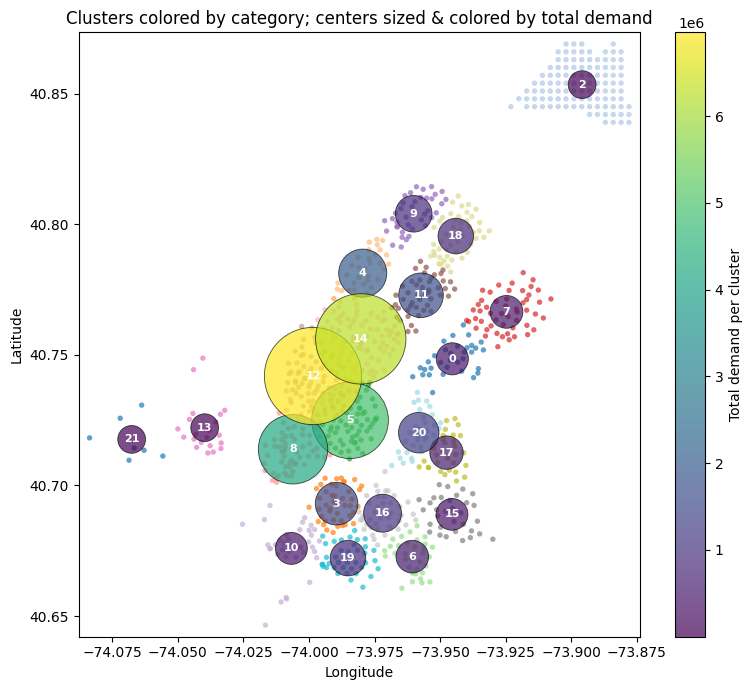

In [21]:
def plot_clustered_demand_map(
    df_demand: pd.DataFrame,
    clustered_stations_kmeans: pd.DataFrame
):
    #Sum total demand per cluster (across whole dataset)
    cluster_total = (df_demand
                    .groupby('cluster', as_index=False)['demand']
                    .sum())

    #Compute cluster centers from stations (mean lat/lon per cluster)
    cluster_centers = (clustered_stations_kmeans
                    .groupby('cluster')[['latitude','longitude']]
                    .mean())

    #Merge totals with centers; drop clusters with no coordinates (and optional: drop noise = -1)
    plot_df = (cluster_total
            .merge(cluster_centers.reset_index(), on='cluster', how='left')
            .dropna(subset=['latitude','longitude']))
    plot_df = plot_df[plot_df['cluster'] != -1]  # comment out if you want to keep noise

    #Prepare size & color by demand (continuous colormap)
    max_d = plot_df['demand'].max()
    min_d = plot_df['demand'].min()

    # matplotlib 's' is area (points^2). We'll scale smoothly with demand.
    sizes = ((plot_df['demand'] / max_d) * 50 + 20)**2

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min_d, vmax=max_d)

    #Background: plot all stations colored by cluster (categorical)
    stations_bg = clustered_stations_kmeans.copy()
    stations_bg = stations_bg.dropna(subset=['latitude','longitude'])
    stations_bg = stations_bg[stations_bg['cluster'] != -1]  # drop noise from background

    unique_clusters = np.sort(stations_bg['cluster'].unique())
    tab20 = plt.cm.get_cmap('tab20', 20)
    cluster_colors = {c: tab20(int(i % 20)) for i, c in enumerate(unique_clusters)}

    #Plot
    fig, ax = plt.subplots(figsize=(8, 7))

    # background station points by cluster (faint)
    ax.scatter(
        stations_bg['longitude'].values,
        stations_bg['latitude'].values,
        c=[cluster_colors[c] for c in stations_bg['cluster'].values],
        s=15, alpha=0.7, linewidths=0
    )

    # overlay cluster centers sized & colored by total demand (with outline)
    sc = ax.scatter(
        plot_df['longitude'].values,
        plot_df['latitude'].values,
        s=sizes.values,
        c=plot_df['demand'].values,
        cmap=cmap, norm=norm,
        edgecolor='black', linewidths=0.6, alpha=0.70,
        zorder=3
    )

    # optional: annotate cluster IDs on centers
    for _, r in plot_df.iterrows():
        ax.text(r['longitude'], r['latitude'], f"{int(r['cluster'])}",
                fontsize=8, ha='center', va='center', color='white', weight='bold', zorder=4)

    # colorbar for demand
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Total demand per cluster')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Clusters colored by category; centers sized & colored by total demand')

    # make the lon/lat map look right-ish
    ax.set_aspect('equal', adjustable='datalim')
    ax.margins(0.02)
    plt.tight_layout()
    plt.show()

plot_clustered_demand_map(df_demand, clustered_stations_kmeans)


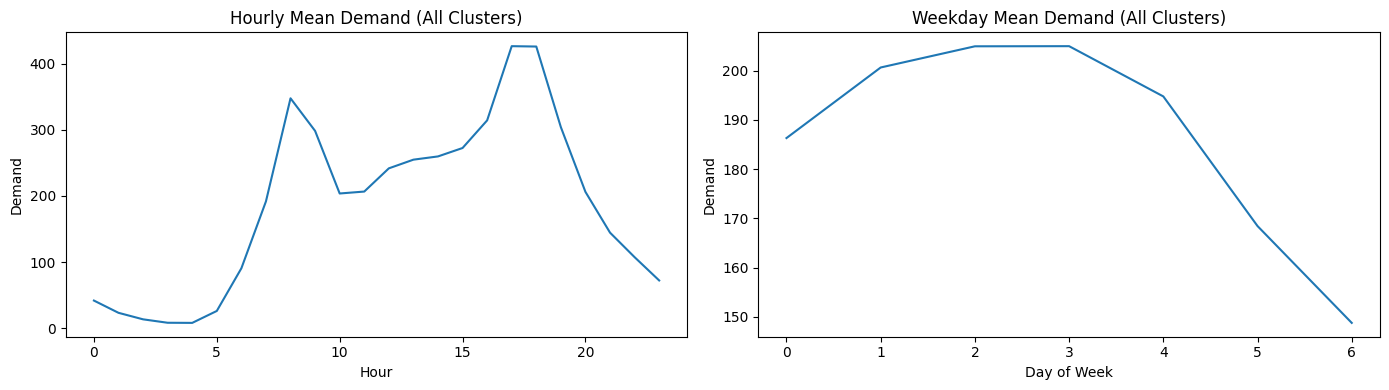

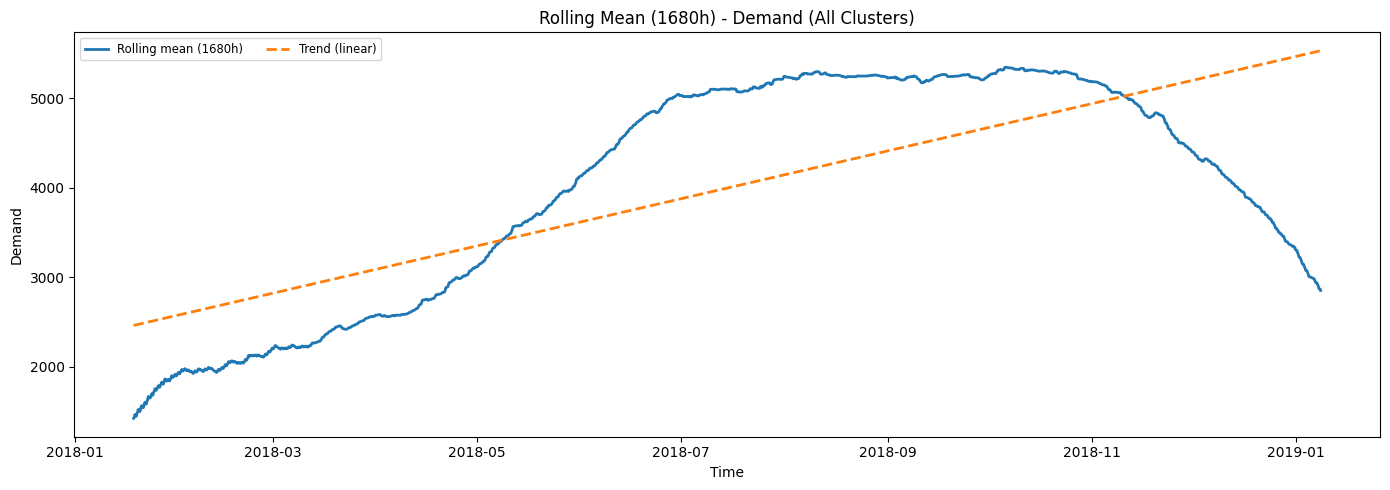

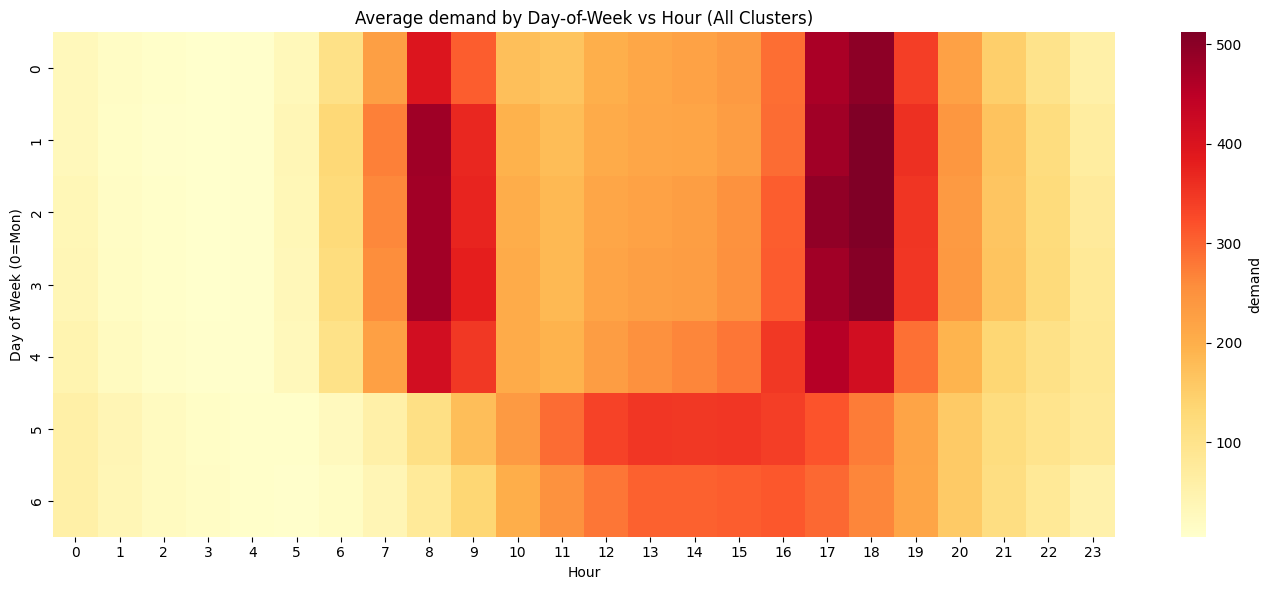

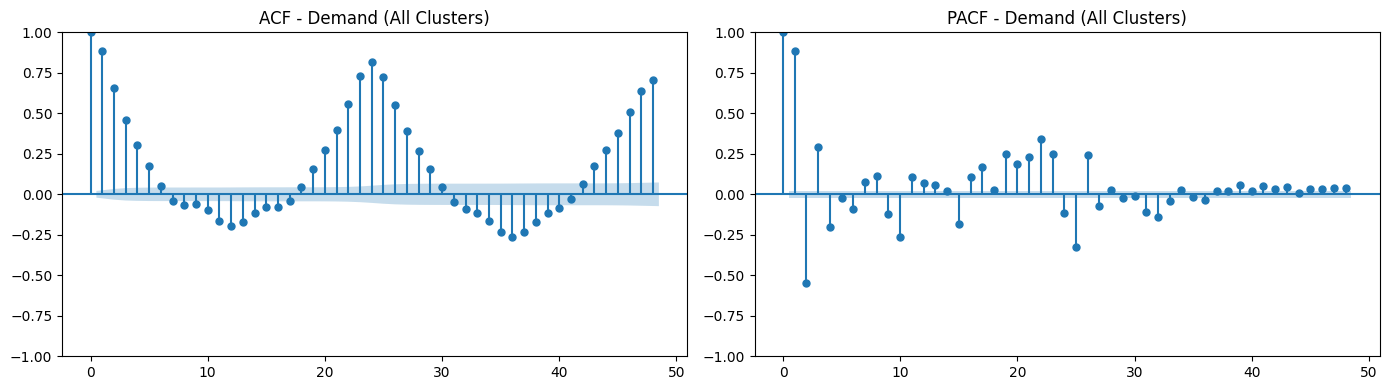

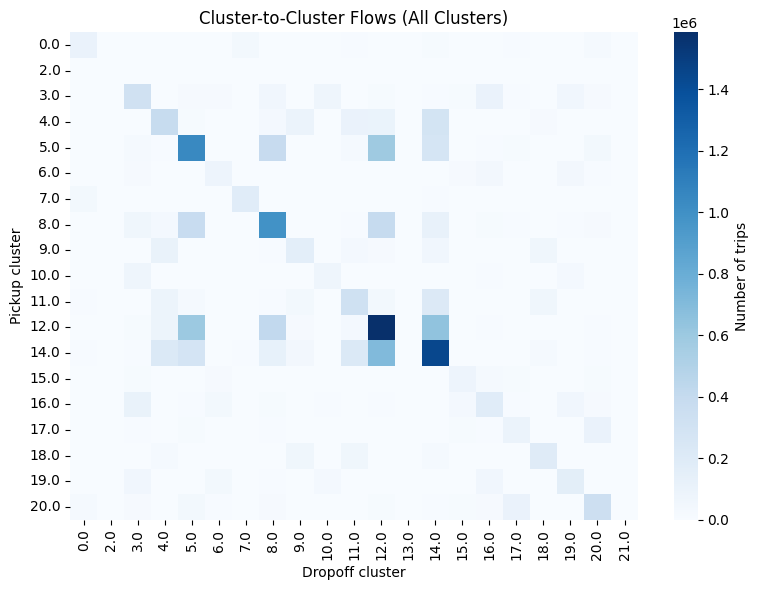

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_demand_time_series_analysis(
    df_demand: pd.DataFrame,
    df_flows: pd.DataFrame | None = None,   # optional: trip-level data for flows
    pu_col: str = "pickup_cluster",         # pickup cluster column name in df_flows
    do_col: str = "dropoff_cluster",        # dropoff cluster column name in df_flows
):
    # We expect columns: ["datetime", "cluster", "pickups", "dropoffs", "demand"]
    df = df_demand.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])

    # ---------- 1) Calendar heatmap ----------
    def calendar_heatmap(df_in, value_col="demand", title_suffix=""):
        d = df_in.copy()
        d["hour"] = d["datetime"].dt.hour
        d["dow"]  = d["datetime"].dt.dayofweek
        pivot = d.pivot_table(index="dow",
                              columns="hour",
                              values=value_col,
                              aggfunc="mean")
        plt.figure(figsize=(14, 6))
        sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={"label": value_col})
        plt.title(f"Average {value_col} by Day-of-Week vs Hour {title_suffix}")
        plt.xlabel("Hour")
        plt.ylabel("Day of Week (0=Mon)")
        plt.tight_layout()

    # ---------- 2) Seasonal line plots ----------
    def seasonal_lineplots(df_in, title_suffix=""):
        d = df_in.copy()

        # average demand by hour-of-day / day-of-week across all clusters
        hourly_mean = d.groupby(d["datetime"].dt.hour)["demand"].mean()
        dow_mean    = d.groupby(d["datetime"].dt.dayofweek)["demand"].mean()

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        hourly_mean.plot(ax=axes[0])
        axes[0].set_title(f"Hourly Mean Demand {title_suffix}")
        axes[0].set_xlabel("Hour")
        axes[0].set_ylabel("Demand")

        dow_mean.plot(ax=axes[1])
        axes[1].set_title(f"Weekday Mean Demand {title_suffix}")
        axes[1].set_xlabel("Day of Week")
        axes[1].set_ylabel("Demand")

        plt.tight_layout()

    # ---------- 3) Rolling stats ----------
    def rolling_stats(df_in, window=1680, title_suffix=""):
        # aggregate to a single time series (sum over clusters per timestamp)
        ts = (
            df_in.groupby("datetime")["demand"]
            .sum()
            .sort_index()
        ).astype(float)

        s = ts
        rm = s.rolling(window, min_periods=max(1, window // 4)).mean()

        plt.figure(figsize=(14, 5))
        plt.plot(rm.index, rm.values, linewidth=2.0,
                 label=f"Rolling mean ({window}h)")

        # trend line on rolling mean
        valid = rm.notna()
        if valid.sum() > 1:
            x = np.arange(valid.sum())
            y = rm[valid].to_numpy()
            coef = np.polyfit(x, y, 1)
            yhat = coef[0] * x + coef[1]
            plt.plot(rm.index[valid], yhat, linestyle="--", linewidth=2.0,
                     label="Trend (linear)")

        plt.title(f"Rolling Mean ({window}h) - Demand {title_suffix}")
        plt.xlabel("Time")
        plt.ylabel("Demand")
        plt.legend(loc="upper left", ncol=2, fontsize="small")
        plt.tight_layout()

    # ---------- 4) ACF / PACF ----------
    def correlation_plots(df_in, title_suffix=""):
        ts = (
            df_in.groupby("datetime")["demand"]
            .sum()
            .sort_index()
        ).astype(float)

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        plot_acf(ts, lags=48, ax=axes[0])
        axes[0].set_title(f"ACF - Demand {title_suffix}")
        plot_pacf(ts, lags=48, ax=axes[1])
        axes[1].set_title(f"PACF - Demand {title_suffix}")
        plt.tight_layout()

    # ---------- 5) Cluster–to–cluster flow matrix ----------
    def cluster_flow_matrix(df_flows_in, title_suffix=""):
        """
        Expects df_flows_in to have one row per trip (or movement),
        with columns `pu_col` (pickup cluster) and `do_col` (dropoff cluster).
        """
        flow = pd.crosstab(df_flows_in[pu_col], df_flows_in[do_col])

        plt.figure(figsize=(8, 6))
        sns.heatmap(flow, cmap="Blues", cbar_kws={"label": "Number of trips"})
        plt.title(f"Cluster-to-Cluster Flows {title_suffix}")
        plt.xlabel("Dropoff cluster")
        plt.ylabel("Pickup cluster")
        plt.tight_layout()

    # ---------- Run all plots ----------
    seasonal_lineplots(df, "(All Clusters)")
    rolling_stats(df, title_suffix="(All Clusters)")
    calendar_heatmap(df, "demand", "(All Clusters)")
    correlation_plots(df, title_suffix="(All Clusters)")

    if df_flows is not None:
        cluster_flow_matrix(df_flows, title_suffix="(All Clusters)")


# if you also have trip-level data with pickup/dropoff clusters:
# df_trips columns example: ["pickup_cluster", "dropoff_cluster", ...]
plot_demand_time_series_analysis(df_demand, df_flows=df_kmeans_clustered,
                                 pu_col="start_cluster",
                                 do_col="end_cluster")


---

## WEATHER DATA

In [23]:

# Central Park area
cp = Point(40.783, -73.966)

start, end = datetime(2018, 1, 1), datetime(2019, 1, 1)
weather_data = Hourly(cp, start, end, timezone='America/New_York').fetch()
#weather_data.to_csv("nyc_weather_hourly_2018_meteostat.csv")

print("Data shape:", weather_data.shape)
print(weather_data.head())


Data shape: (8761, 11)
                           temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
time                                                                         
2018-01-01 00:00:00-05:00 -10.6 -15.5  67.0   0.0  <NA>  340.0  11.2  <NA>   
2018-01-01 01:00:00-05:00 -11.1 -17.1  61.0   0.0  <NA>  330.0   9.4  <NA>   
2018-01-01 02:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  330.0   7.6  <NA>   
2018-01-01 03:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  330.0   7.6  <NA>   
2018-01-01 04:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  310.0  11.2  <NA>   

                             pres  tsun  coco  
time                                           
2018-01-01 00:00:00-05:00  1026.9  <NA>  <NA>  
2018-01-01 01:00:00-05:00  1027.1  <NA>  <NA>  
2018-01-01 02:00:00-05:00  1027.4  <NA>  <NA>  
2018-01-01 03:00:00-05:00  1027.6  <NA>  <NA>  
2018-01-01 04:00:00-05:00  1027.7  <NA>  <NA>  


In [24]:
def prepare_weather_hourly(weather: pd.DataFrame) -> pd.DataFrame:
    w = weather.copy()
    w.index = pd.to_datetime(w.index)        
    w.index = w.index.tz_localize(None)        

    # Resample to strict hourly grid
    w = w.sort_index().resample("H").agg({"temp": "mean", "prcp": "sum"})

    w.index.name = "datetime"
    return w.astype("float64")



weather_hourly = prepare_weather_hourly(weather_data)


weather_hourly


,temp,prcp
datetime,,
2018-01-01 00:00:00,-10.6,0.0
2018-01-01 01:00:00,-11.1,0.0
2018-01-01 02:00:00,-11.7,0.0
2018-01-01 03:00:00,-11.7,0.0
2018-01-01 04:00:00,-11.7,0.0
...,...,...
2018-12-31 20:00:00,6.7,4.5
2018-12-31 21:00:00,7.2,3.8
2018-12-31 22:00:00,7.2,4.3


In [25]:
def exog_from_weather(weather_hourly: pd.DataFrame,
                      target_index: pd.DatetimeIndex) -> np.ndarray:
    idx = pd.DatetimeIndex(target_index)
    if idx.tz is not None:
        idx = idx.tz_localize(None)

    # Reindex and (re)fill safely
    X = weather_hourly.reindex(idx).copy()
    if "temp" in X.columns:
        X["temp"] = X["temp"].interpolate("time").ffill().bfill()
    if "prcp" in X.columns:
        X["prcp"] = X["prcp"].fillna(0.0)

    return X[["temp", "prcp"]].to_numpy(dtype="float64")


---

# FORECAST / FUTURE PREDICTION - TASK 2

In [ ]:
CONFIG = {
    'pickup_clusters': None,         # -> None = all
    'dropoff_clusters': None,       # -> None = top N
    'top_n': 5,
    
    # Date-based split
    'train_start': "2018-01-01",
    'train_end':   "2018-10-31",
    'test_start':  "2018-11-01",
    'test_end':    "2018-12-31",
    
    'result_path': "results"
}

os.makedirs(CONFIG['result_path'], exist_ok=True)

In [36]:
df_demand.head()

,datetime,cluster,pickups,dropoffs,demand
0,2018-01-01,0.0,1.0,0.0,1.0
1,2018-01-01,2.0,0.0,0.0,0.0
2,2018-01-01,3.0,2.0,1.0,3.0
3,2018-01-01,4.0,8.0,4.0,12.0
4,2018-01-01,5.0,18.0,20.0,38.0


In [39]:

def to_wide(df_long_hourly: pd.DataFrame, value_col) -> pd.DataFrame:
    w = (df_long_hourly
         .pivot(index="datetime", columns="cluster", values=value_col)
         .sort_index()
         .asfreq("h", fill_value=0.0)
         .astype("float64"))
    # Ensure DatetimeIndex and no tz
    w.index = pd.to_datetime(w.index)
    return w

def split_train_test_long(
    df_long_hourly: pd.DataFrame,
    train_start: str | pd.Timestamp,
    train_end: str | pd.Timestamp,
    test_start: str | pd.Timestamp,
    test_end: str | pd.Timestamp,
    value_col: str = "pickups",
    clusters: Iterable | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    d = df_long_hourly.copy()
    d["datetime"] = pd.to_datetime(d["datetime"])
    d = d[["datetime", "cluster", value_col]]

    # Optional cluster filtering
    if clusters is not None:
        d = d[d["cluster"].isin(list(clusters))].copy()

    # Ensure timestamps
    train_start_ts = pd.to_datetime(train_start)
    train_end_ts   = pd.to_datetime(train_end)
    test_start_ts  = pd.to_datetime(test_start)
    test_end_ts    = pd.to_datetime(test_end)

    # Date-based masks (inclusive ranges)
    train_mask = (d["datetime"] >= train_start_ts) & (d["datetime"] <= train_end_ts)
    test_mask  = (d["datetime"] >= test_start_ts)  & (d["datetime"] <= test_end_ts)

    train = d[train_mask].copy()
    test  = d[test_mask].copy()

    return train, test

train_long_pickups, test_long_pickups = split_train_test_long(
    df_demand,
    train_start=CONFIG['train_start'],
    train_end=CONFIG['train_end'],
    test_start=CONFIG['test_start'],
    test_end=CONFIG['test_end'],
    value_col="pickups",
    clusters=sorted(df_demand['cluster'].dropna().unique().tolist()) if CONFIG['pickup_clusters'] == None else CONFIG['pickup_clusters'],
)

### Evaluation and visualization

In [40]:
def evaluate_predictions(
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    eps: float = 1e-12,
) -> dict:

    # Align and fill
    y_true = y_test_wide.reindex(index=y_pred_wide.index, columns=y_pred_wide.columns).fillna(0.0).astype("float64")
    y_pred = y_pred_wide.reindex_like(y_true).fillna(0.0).astype("float64")

    err = y_true - y_pred
    mae = err.abs().mean(axis=0)
    rmse = np.sqrt((err.pow(2)).mean(axis=0))
    wape = err.abs().sum(axis=0) / (y_true.abs().sum(axis=0) + eps)

    per_cluster = pd.DataFrame({"MAE": mae, "RMSE": rmse, "WAPE": wape}).sort_values("WAPE")

    overall = {
        "MAE": float(err.abs().to_numpy().mean()),
        "RMSE": float(np.sqrt((err.pow(2)).to_numpy().mean())),
        "WAPE": float(err.abs().to_numpy().sum() / (y_true.abs().to_numpy().sum() + eps)),
    }
    return {"per_cluster": per_cluster, "overall": overall}


def plot_test_period_cluster(
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    cluster: str | int,
    title_prefix: str = "Pickups",
    show_day_grid: bool = True,
):
    idx = y_test_wide.index.union(y_pred_wide.index)
    y_true = y_test_wide[cluster].reindex(idx).fillna(0.0).astype("float64")
    y_pred = y_pred_wide[cluster].reindex(idx).fillna(0.0).astype("float64")

    err = y_true - y_pred
    wape = float(err.abs().sum() / (y_true.abs().sum() + 1e-12))
    mae  = float(err.abs().mean())
    rmse = float(np.sqrt((err.pow(2)).mean()))

    plt.figure(figsize=(14, 4))
    plt.plot(y_true.index, y_true.values, label="Test (actual)", linewidth=1.2)
    plt.plot(y_pred.index, y_pred.values, label="SARIMA (pred)", linewidth=1.2)
    plt.title(f"{title_prefix} - cluster {cluster} - full test period\n"
              f"WAPE={wape:.3f}  MAE={mae:.2f}  RMSE={rmse:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Pickups")
    plt.legend()
    if show_day_grid:
        # light vertical lines each midnight
        days = pd.date_range(idx.min().normalize(), idx.max().normalize(), freq="D")
        for d in days:
            plt.axvline(d, linewidth=0.5, alpha=0.25)
    plt.tight_layout()
    plt.show()

def plot_test_period_topN(
    metrics: dict,
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    top_n: int,
    best: bool = True,
    title_prefix: str = "Pickups",
):
    order = metrics["per_cluster"].sort_values("WAPE", ascending=True)
    clusters = list(order.index[:top_n]) if best else list(order.index[::-1][:top_n])

    for c in clusters:
        plot_test_period_cluster(y_test_wide, y_pred_wide, c, title_prefix=title_prefix)

def plot_test_period_overall_sum(
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    title_prefix: str = "Pickups (sum over clusters)"
):
    idx = y_test_wide.index.union(y_pred_wide.index)
    y_true = y_test_wide.reindex(idx).fillna(0.0).sum(axis=1).astype("float64")
    y_pred = y_pred_wide.reindex(idx).fillna(0.0).sum(axis=1).astype("float64")

    err = y_true - y_pred
    wape = float(err.abs().sum() / (y_true.abs().sum() + 1e-12))

    plt.figure(figsize=(14, 4))
    plt.plot(y_true.index, y_true.values, label="Test sum (actual)", linewidth=1.2)
    plt.plot(y_pred.index, y_pred.values, label="Pred sum", linewidth=1.2)
    plt.title(f"{title_prefix} full test period - WAPE={wape:.3f}")
    plt.xlabel("Time")
    plt.ylabel("Pickups")
    plt.legend()
    days = pd.date_range(idx.min().normalize(), idx.max().normalize(), freq="d")
    for d in days:
        plt.axvline(d, linewidth=0.5, alpha=0.25)
    plt.tight_layout()
    plt.show()
    

def plot_predicted_day(
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    cluster: str | int,
    day: str | pd.Timestamp,
    title_prefix: str = "Pickups",
):

    day = pd.to_datetime(day).normalize()
    idx_day = pd.date_range(day, day + pd.Timedelta(hours=23), freq="h")

    # Align/clip safely
    y_true = (y_test_wide[[cluster]]
              .reindex(idx_day)
              .fillna(0.0)
              [cluster])
    y_pred = (y_pred_wide[[cluster]]
              .reindex(idx_day)
              .fillna(0.0)
              [cluster])

    plt.figure(figsize=(12, 4))
    plt.plot(y_true.index, y_true.values, label="Test (actual)", linewidth=1.5)
    plt.plot(y_pred.index, y_pred.values, label="SARIMA (pred)", linewidth=1.5)
    plt.title(f"{title_prefix} - cluster {cluster} - {day.date().isoformat()}")
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def save_all_test_period_plots(
    y_test_wide: pd.DataFrame,
    y_pred_wide: pd.DataFrame,
    out_dir: str,
    clusters: list | None = None,
    title_prefix: str = "Pickups",
    show_day_grid: bool = True,
    dpi: int = 150,
    include_overall: bool = True,
):

    os.makedirs(out_dir, exist_ok=True)

    clist = clusters if clusters is not None else list(y_test_wide.columns)

    # Save per-cluster plots
    for c in clist:
        idx = y_test_wide.index.union(y_pred_wide.index)
        y_true = y_test_wide[c].reindex(idx).fillna(0.0).astype("float64")
        y_pred = y_pred_wide[c].reindex(idx).fillna(0.0).astype("float64")

        err = y_true - y_pred
        wape = float(err.abs().sum() / (y_true.abs().sum() + 1e-12))
        mae  = float(err.abs().mean())
        rmse = float(np.sqrt((err.pow(2)).mean()))

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(y_true.index, y_true.values, label="Test (actual)", linewidth=1.2)
        ax.plot(y_pred.index, y_pred.values, label="SARIMA (pred)", linewidth=1.2)
        ax.set_title(f"{title_prefix} - cluster {c} - full test period\n"
                     f"WAPE={wape:.3f}  MAE={mae:.2f}  RMSE={rmse:.2f}")
        ax.set_xlabel("Time"); ax.set_ylabel("Pickups"); ax.legend()

        if show_day_grid:
            days = pd.date_range(idx.min().normalize(), idx.max().normalize(), freq="D")
            for d in days:
                ax.axvline(d, linewidth=0.5, alpha=0.25)

        fig.tight_layout()
        fname = os.path.join(out_dir, f"{str(title_prefix).lower().replace(' ', '_')}_cluster_{str(c)}.png")
        fig.savefig(fname, dpi=dpi, bbox_inches="tight")
        plt.close(fig)

    # Optional overall-sum plot
    if include_overall:
        idx = y_test_wide.index.union(y_pred_wide.index)
        y_true_sum = y_test_wide.reindex(idx).fillna(0.0).sum(axis=1).astype("float64")
        y_pred_sum = y_pred_wide.reindex(idx).fillna(0.0).sum(axis=1).astype("float64")
        wape_sum = float((y_true_sum - y_pred_sum).abs().sum() / (y_true_sum.abs().sum() + 1e-12))

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(y_true_sum.index, y_true_sum.values, label="Test sum (actual)", linewidth=1.2)
        ax.plot(y_pred_sum.index, y_pred_sum.values, label="Pred sum", linewidth=1.2)
        ax.set_title(f"{title_prefix} (sum over clusters) - full test period - WAPE={wape_sum:.3f}")
        ax.set_xlabel("Time"); ax.set_ylabel("Pickups"); ax.legend()

        days = pd.date_range(idx.min().normalize(), idx.max().normalize(), freq="D")
        for d in days:
            ax.axvline(d, linewidth=0.5, alpha=0.25)

        fig.tight_layout()
        fname = os.path.join(out_dir, f"{str(title_prefix).lower().replace(' ', '_')}_overall_sum.png")
        fig.savefig(fname, dpi=dpi, bbox_inches="tight")
        plt.close(fig)


## PICKUP

In [41]:
train_wide_pickups = to_wide(train_long_pickups, value_col="pickups")
test_wide_pickups = to_wide(test_long_pickups, value_col="pickups")

test_wide_pickups

cluster,0.0,2.0
datetime,,
2018-11-01 00:00:00,7.0,1.0
2018-11-01 01:00:00,5.0,0.0
2018-11-01 02:00:00,2.0,0.0
2018-11-01 03:00:00,2.0,0.0
2018-11-01 04:00:00,1.0,0.0
...,...,...
2018-12-30 20:00:00,5.0,0.0
2018-12-30 21:00:00,20.0,0.0
2018-12-30 22:00:00,7.0,0.0


In [42]:
# Build DataFrames from your prepared arrays to keep indices aligned & readable
X_train_weather_df = pd.DataFrame(exog_from_weather(weather_hourly, train_wide_pickups.index), index=train_wide_pickups.index, columns=["temp","prcp"]).astype("float64")
X_test_weather_df  = pd.DataFrame(exog_from_weather(weather_hourly, test_wide_pickups.index),  index=test_wide_pickups.index,  columns=["temp","prcp"]).astype("float64")


X_train_weather_df

,temp,prcp
datetime,,
2018-01-01 00:00:00,-10.6,0.0
2018-01-01 01:00:00,-11.1,0.0
2018-01-01 02:00:00,-11.7,0.0
2018-01-01 03:00:00,-11.7,0.0
2018-01-01 04:00:00,-11.7,0.0
...,...,...
2018-10-30 20:00:00,12.2,0.0
2018-10-30 21:00:00,11.7,0.0
2018-10-30 22:00:00,11.1,0.0


In [43]:

def _seasonal_naive_fallback(y_train: pd.Series, horizon_index: pd.DatetimeIndex) -> pd.Series:
    # Repeat the last 24 hours from y_train (or zeros) over the given horizon
    if len(y_train) >= 24 and y_train.abs().sum() > 0:
        pattern = y_train.iloc[-24:].to_numpy()
        reps = int(np.ceil(len(horizon_index) / 24))
        yhat = np.tile(pattern, reps)[:len(horizon_index)]
    else:
        yhat = np.zeros(len(horizon_index), dtype="float64")
    return pd.Series(yhat, index=horizon_index, name=y_train.name)


def sarima_pickup_day_forecast(
    train_wide: pd.DataFrame,
    test_wide: pd.DataFrame,
    X_train: np.ndarray,
    X_test: np.ndarray,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
):

    train_wide = train_wide.sort_index().astype("float64")
    test_wide  = test_wide.sort_index().astype("float64")
    
    # Wrap exog to DataFrames with matching indices (keeps speed + alignment)
    def _to_exog_df(X, idx):
        if isinstance(X, pd.DataFrame):
            df = X.copy()
            # ensure same index & order
            if not df.index.equals(idx):
                df = df.reindex(idx)
        else:
            df = pd.DataFrame(X, index=idx)
        # float64 for statsmodels stability
        return df.astype("float64")

    X_train_df = _to_exog_df(X_train, train_wide.index)
    X_test_df  = _to_exog_df(X_test,  test_wide.index)

    # sanity checks
    assert len(X_train_df) == len(train_wide.index)
    assert len(X_test_df)  == len(test_wide.index)
    
    preds = pd.DataFrame(index=test_wide.index, columns=test_wide.columns, dtype="float64")

    # Day anchors inside test set (only days that exist in test_wide)
    day_starts = pd.DatetimeIndex(sorted(set(test_wide.index.floor("d"))))

    for cid in tqdm(test_wide.columns, desc="Clusters", dynamic_ncols=True):
        y_train = train_wide[cid]
        
        # trivial fallback
        if (y_train.abs().sum() == 0) or (len(y_train) < 48):
            preds[cid] = _seasonal_naive_fallback(y_train, preds.index)
            continue

        res = SARIMAX(
            y_train,
            exog=X_train_df.values,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)

        for day_start in tqdm(day_starts, desc=f"Days ({cid})", leave=False, position=1, dynamic_ncols=True):
            # 24h horizon of that day, restricted to what exists in test_wide
            idx24 = pd.date_range(day_start, periods=24, freq="h")
            idx24 = idx24.intersection(test_wide.index)
            if len(idx24) == 0:
                continue

            # exog for that day (aligned to idx24)
            exog_day = X_test_df.loc[idx24].to_numpy(dtype="float64")

            fc = res.get_forecast(steps=len(idx24), exog=exog_day).predicted_mean
            preds.loc[idx24, cid] = fc.to_numpy(dtype="float64")

            # Append observed 24h to update the state (no refit)
            y_obs = test_wide.loc[idx24, cid].to_numpy(dtype="float64")

            try:
                res = res.append(y_obs, exog=exog_day, refit=False)
            except TypeError:
                # fallback: rebuild results on concatenated endog/exog and FILTER with existing params (no refit)
                endog_full = np.r_[res.model.endog, y_obs]
                exog_full  = np.vstack([res.model.exog, exog_day])
                mod2 = SARIMAX(
                    endog_full,
                    exog=exog_full,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = mod2.filter(res.params)  # reuse current params, no refit
    return preds.fillna(0.0).clip(lower=0).astype("float64")


pickups_pred_wide = sarima_pickup_day_forecast(
    train_wide_pickups,
    test_wide_pickups,
    X_train_weather_df,
    X_test_weather_df,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
)


Clusters:   0%|          | 0/2 [00:00<?, ?it/s]

Days (0.0):   0%|          | 0/61 [00:00<?, ?it/s]

Days (2.0):   0%|          | 0/61 [00:00<?, ?it/s]

In [44]:
pickups_pred_wide.to_csv(os.path.join(CONFIG['result_path'], "Predicted_pickups.csv"), index=True)

metrics_pickups = evaluate_predictions(test_wide_pickups, pickups_pred_wide)

print("Overall:", metrics_pickups["overall"])
print("\nTop clusters by WAPE:\n", metrics_pickups["per_cluster"].head(10))

per_cluster_path = os.path.join(CONFIG['result_path'], "pickup_metrics_per_cluster.csv")
metrics_pickups["per_cluster"].to_csv(per_cluster_path, index=True)

overall_path = os.path.join(CONFIG['result_path'], "pickup_metrics_overall.json")
with open(overall_path, "w", encoding="utf-8") as f:
    json.dump(metrics_pickups["overall"], f, indent=2)

Overall: {'MAE': 4.8532618825604255, 'RMSE': 9.587980891586826, 'WAPE': 0.5158246328934631}

Top clusters by WAPE:
               MAE       RMSE      WAPE
cluster                               
0.0      9.493373  13.552350  0.507661
2.0      0.213151   0.438815  1.817459


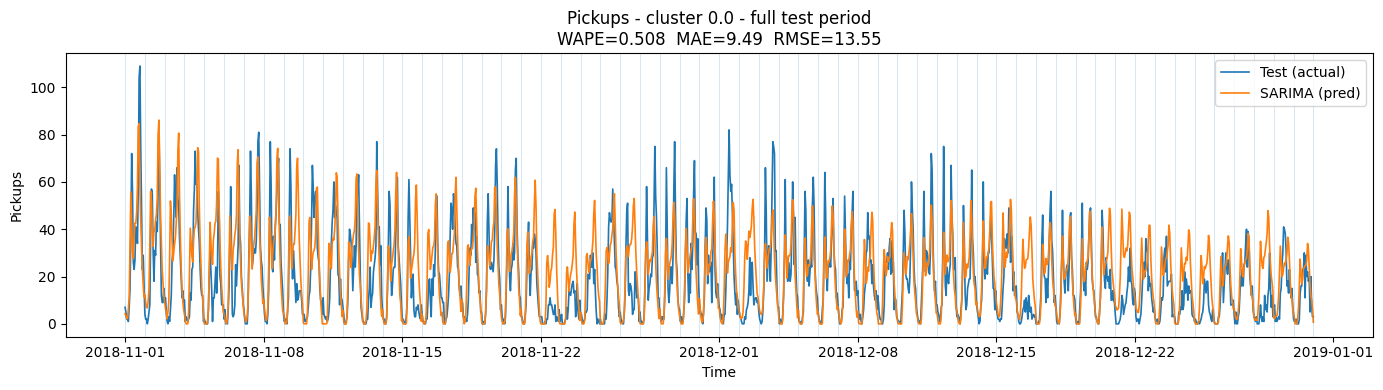

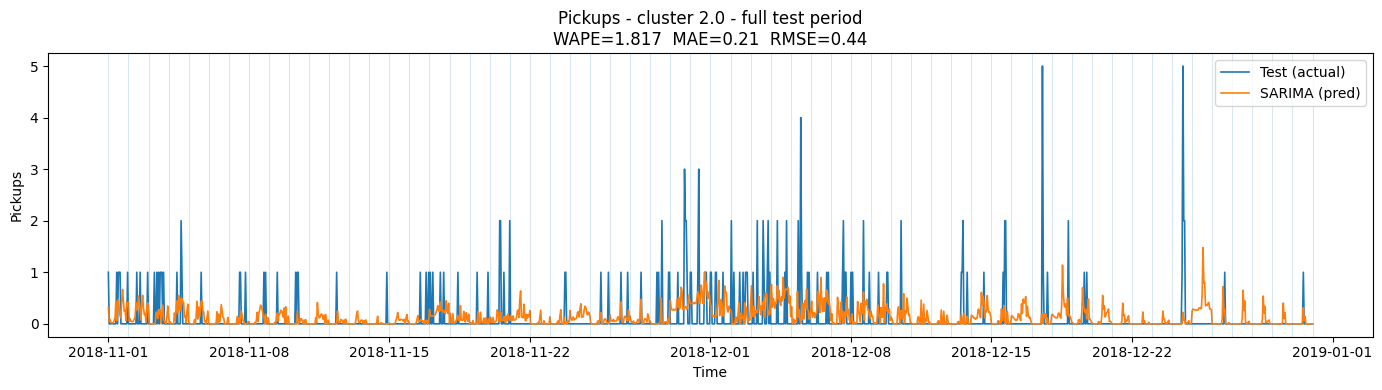

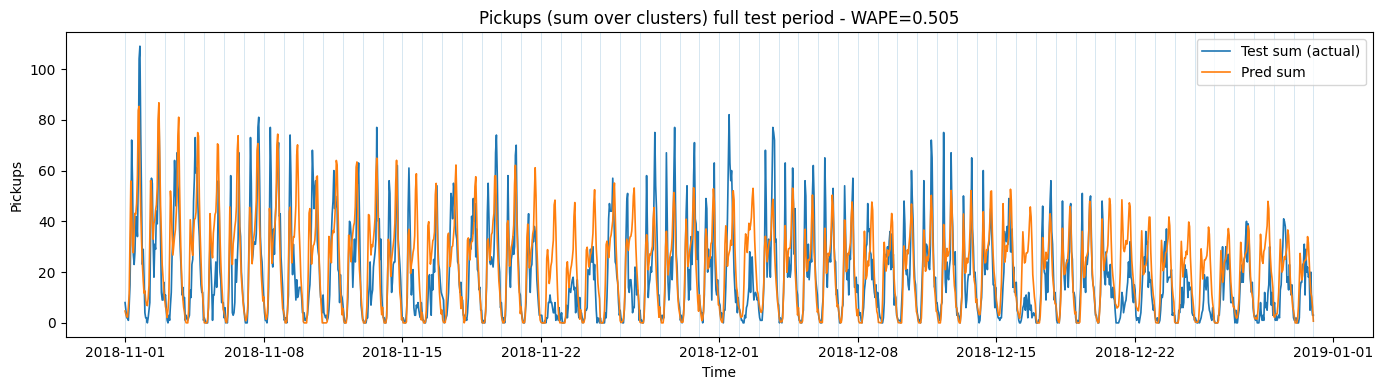

In [45]:
plot_test_period_topN(metrics_pickups, test_wide_pickups, pickups_pred_wide, top_n=CONFIG['top_n'], best=True)
plot_test_period_overall_sum(test_wide_pickups, pickups_pred_wide)


plots_dir = os.path.join(CONFIG["result_path"], "plots_pickups_test")
os.makedirs(plots_dir, exist_ok=True)

save_all_test_period_plots(
    y_test_wide=test_wide_pickups,
    y_pred_wide=pickups_pred_wide,
    out_dir=plots_dir,
    title_prefix="Pickups",
    include_overall=True
)


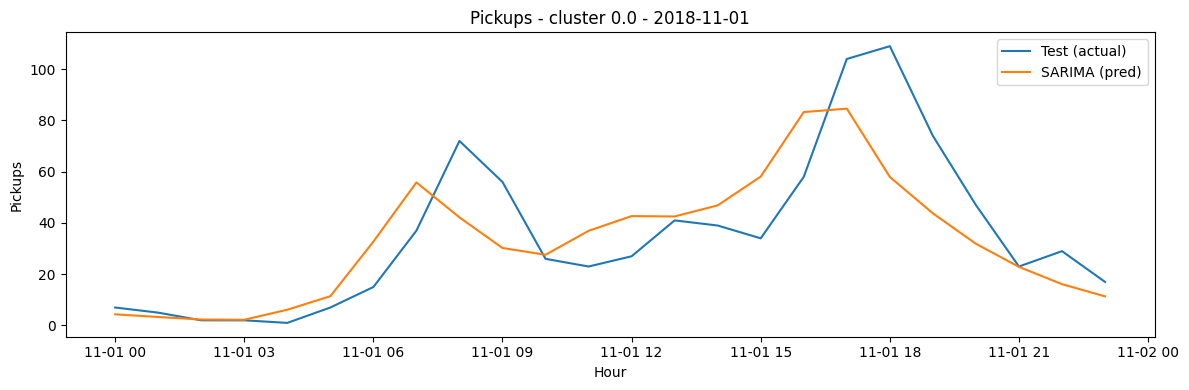

In [46]:
    
best_cluster = metrics_pickups["per_cluster"].index[0]
first_test_day = test_wide_pickups.index.min().date()
plot_predicted_day(test_wide_pickups, pickups_pred_wide, cluster=best_cluster, day=str(first_test_day))


## DROP OFF

In [ ]:
best_clusters = metrics_pickups["per_cluster"].head(CONFIG['top_n']).index.tolist()

train_long_dropoffs, test_long_dropoffs = split_train_test_long(
    df_demand,
    train_start=CONFIG['train_start'],
    train_end=CONFIG['train_end'],
    test_start=CONFIG['test_start'],
    test_end=CONFIG['test_end'],
    value_col="dropoffs",
    clusters=best_clusters,
)

In [162]:
train_wide_dropoffs = to_wide(train_long_dropoffs, value_col="dropoffs")
test_wide_dropoffs = to_wide(test_long_dropoffs, value_col="dropoffs")

train_wide_dropoffs

cluster,0.0,2.0,3.0
datetime,,,
2018-01-01 00:00:00,0.0,0.0,1.0
2018-01-01 01:00:00,2.0,0.0,4.0
2018-01-01 02:00:00,2.0,0.0,3.0
2018-01-01 03:00:00,1.0,0.0,1.0
2018-01-01 04:00:00,2.0,0.0,1.0
...,...,...,...
2018-10-30 20:00:00,42.0,0.0,88.0
2018-10-30 21:00:00,19.0,0.0,74.0
2018-10-30 22:00:00,11.0,0.0,53.0


In [164]:
def sarimax_dropoffs_with_pickup_forecasts(
    train_wide_drop: pd.DataFrame,
    test_wide_drop: pd.DataFrame,
    exog_train_pick_act: pd.DataFrame,  
    exog_test_pick_act: pd.DataFrame,   # for APPEND step
    exog_test_pick_pred: pd.DataFrame,  # for FORECAST step
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    show_progress: bool = True,
) -> pd.DataFrame:

    # Use train exog columns as canonical order
    exog_cols = list(exog_train_pick_act.columns)
    exog_test_pick_act = exog_test_pick_act.reindex(columns=exog_cols).fillna(0.0).astype("float64")
    exog_test_pick_pred = exog_test_pick_pred.reindex(columns=exog_cols).fillna(0.0).astype("float64")

    # Target clusters to predict
    clist = list(test_wide_drop.columns)

    test_idx   = test_wide_drop.index
    day_starts = pd.date_range(test_idx.min().floor("d"), test_idx.max().floor("d"), freq="d")

    preds = pd.DataFrame(index=test_idx, columns=clist, dtype="float64")

    outer = clist if not show_progress else tqdm(clist, desc="SARIMAX dropoffs per cluster", dynamic_ncols=True)
    for cid in outer:
        # Align train endog/exog
        y_train = train_wide_drop[cid].reindex(exog_train_pick_act.index).fillna(0.0)
        X_train = exog_train_pick_act.loc[y_train.index, exog_cols].fillna(0.0)

        res = SARIMAX(
            endog=y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)

        inner_days = day_starts if not show_progress else tqdm(day_starts, desc=f"Days ({cid})", leave=False, position=1, dynamic_ncols=True)
        for d0 in inner_days:
            idx24_all = pd.date_range(d0, periods=24, freq="h")
            idx24 = idx24_all.intersection(test_idx)
            if len(idx24) == 0:
                continue

            # 1) FORECAST using *predicted pickups* for that day
            X_fc = exog_test_pick_pred.loc[idx24, exog_cols].fillna(0.0)
            fc = res.get_forecast(steps=len(idx24), exog=X_fc).predicted_mean
            preds.loc[idx24, cid] = fc.to_numpy(dtype="float64")

            # 2) APPEND using *actual* dropoffs + *actual* pickups (no refit)
            y_obs = test_wide_drop.loc[idx24, cid].to_numpy(dtype="float64")
            X_obs = exog_test_pick_act.loc[idx24, exog_cols].fillna(0.0)
            res = res.append(y_obs, exog=X_obs, refit=False)

    return preds.fillna(0.0).clip(lower=0).astype("float64")


dropoffs_pred_wide = sarimax_dropoffs_with_pickup_forecasts(
    train_wide_drop=train_wide_dropoffs,
    test_wide_drop=test_wide_dropoffs,
    exog_train_pick_act=train_wide_pickups,
    exog_test_pick_act=test_wide_pickups,     # used only for APPEND
    exog_test_pick_pred=pickups_pred_wide,    # used for FORECAST
    order=(1,1,1),
    seasonal_order=(1,1,1,24),
    show_progress=True
)


SARIMAX dropoffs per cluster:   0%|          | 0/3 [00:00<?, ?it/s]

Days (0.0):   0%|          | 0/61 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [166]:
dropoffs_pred_wide.to_csv(os.path.join(CONFIG['result_path'], "Predicted_dropoffs.csv"), index=True)

metrics_dropoff = evaluate_predictions(test_wide_dropoffs, dropoffs_pred_wide)

print("Overall:", metrics_dropoff["overall"])
print("\nTop clusters by WAPE:\n", metrics_dropoff["per_cluster"].head(10))

per_cluster_path = os.path.join(CONFIG['result_path'], "dropoff_metrics_per_cluster.csv")
metrics_dropoff["per_cluster"].to_csv(per_cluster_path, index=True)

overall_path = os.path.join(CONFIG['result_path'], "dropoff_metrics_overall.json")
with open(overall_path, "w", encoding="utf-8") as f:
    json.dump(metrics_dropoff["overall"], f, indent=2)

Overall: {'MAE': 12.372709408246914, 'RMSE': 25.832677583932956, 'WAPE': 0.4568192990712492}

Top clusters by WAPE:
            MAE       RMSE      WAPE
3.0  27.954758  42.619201  0.446422
0.0   8.949218  13.616226  0.483260
2.0   0.214152   0.428758  1.855135


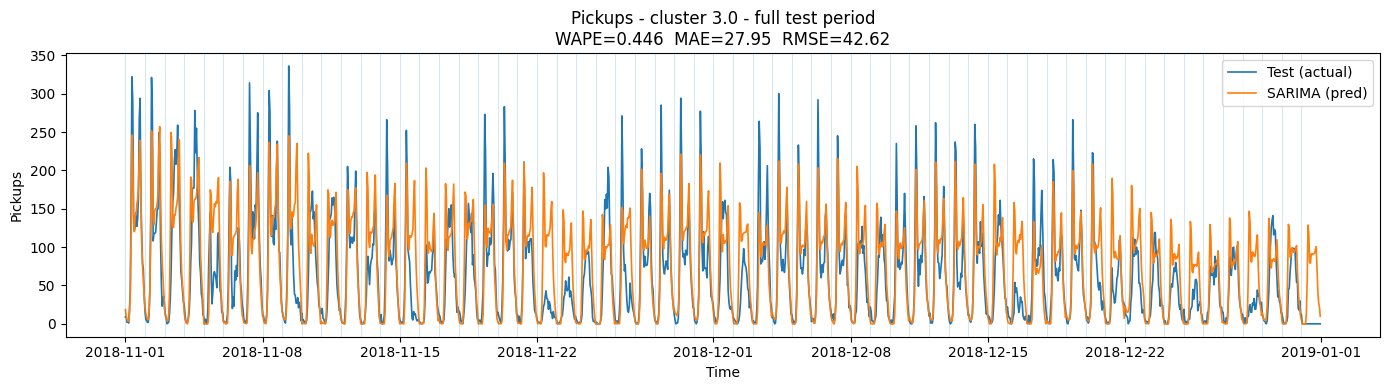

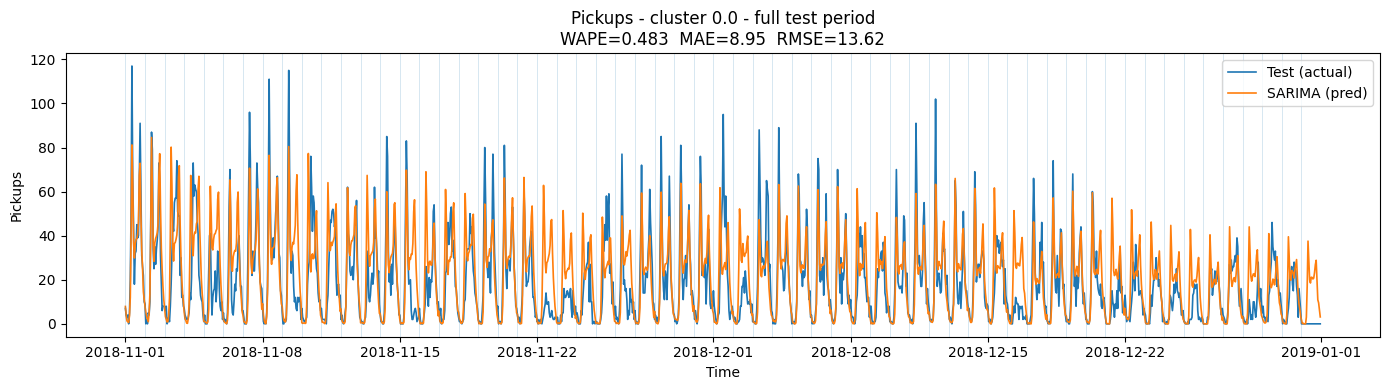

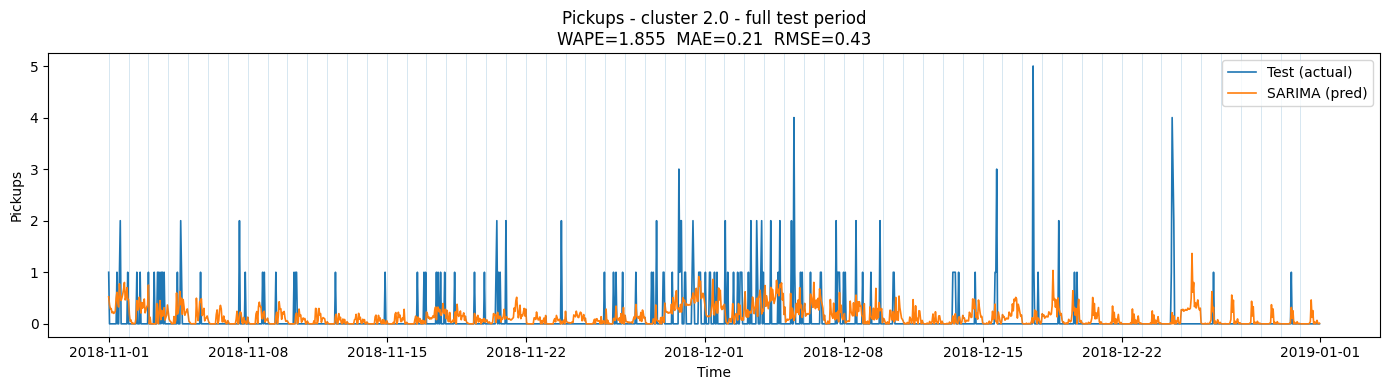

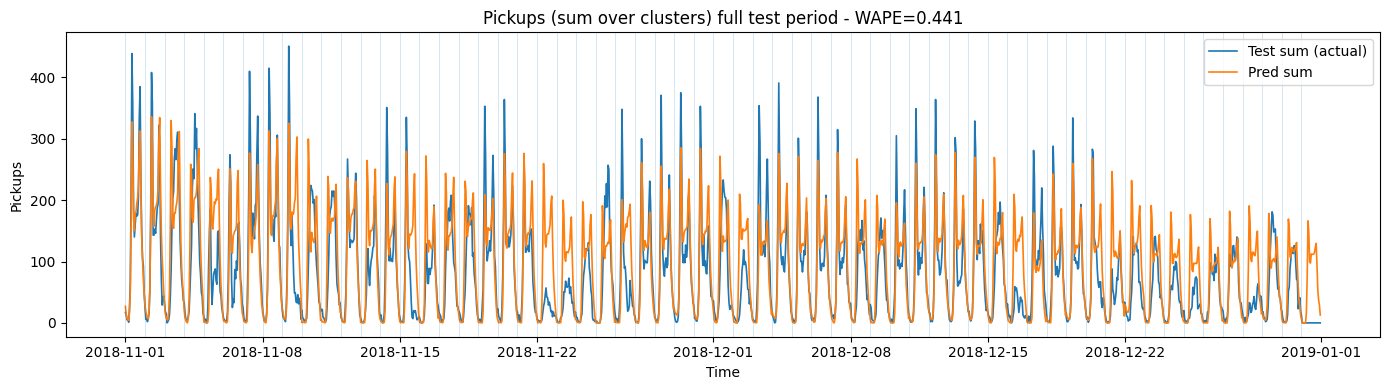

In [172]:
plot_test_period_topN(metrics_dropoff, test_wide_dropoffs, dropoffs_pred_wide, top_n=CONFIG['top_n'], best=True)
plot_test_period_overall_sum(test_wide_dropoffs, dropoffs_pred_wide)


plots_dir = os.path.join(CONFIG["result_path"], "plots_dropoffs_test")
os.makedirs(plots_dir, exist_ok=True)

save_all_test_period_plots(
    y_test_wide=test_wide_dropoffs,
    y_pred_wide=dropoffs_pred_wide,
    out_dir=plots_dir,
    title_prefix="Dropoffs",
    include_overall=True
)


C:\Users\Tomi\AppData\Local\Temp\ipykernel_11260\939872977.py:107: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_day = pd.date_range(day, day + pd.Timedelta(hours=23), freq="H")


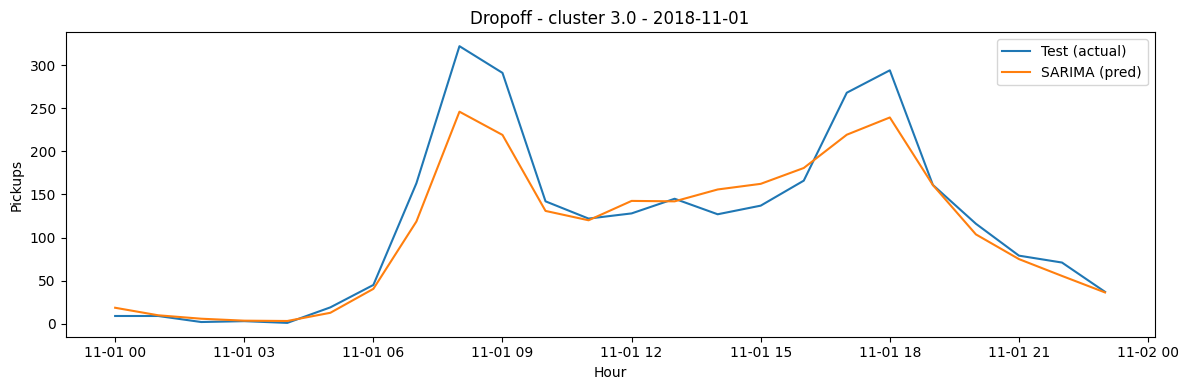

In [174]:
best_cluster = metrics_dropoff["per_cluster"].index[0]
first_test_day = test_wide_dropoffs.index.min().date()
plot_predicted_day(test_wide_dropoffs, dropoffs_pred_wide, cluster=best_cluster, day=str(first_test_day), title_prefix="Dropoff")

---

# Bike rebalancing between clusters - TASK 3

In [216]:

def compute_required_bikes_for_days(
    pickups_wide: pd.DataFrame,
    dropoffs_wide: pd.DataFrame,
) -> pd.DataFrame:

    # Align and fill
    pickups = pickups_wide.copy()
    dropoffs = dropoffs_wide.reindex_like(pickups)
    
    pickups = pickups.apply(np.ceil)
    dropoffs = dropoffs.apply(np.floor)

    # Long format: one row per datetime & cluster
    df = pickups.stack().to_frame("pickups")
    df["dropoffs"] = dropoffs.stack()
    df = df.reset_index().rename(
        columns={"level_0": "datetime", "level_1": "cluster"}
    )
    df["date"] = df["datetime"].dt.date

    def _per_day_cluster(g: pd.DataFrame) -> pd.Series:
        g = g.sort_values("datetime")
        net = g["pickups"] - g["dropoffs"]        # departures - arrivals
        cum_net = net.cumsum()
        required = max(0.0, float(cum_net.max())) # minimal starting stock
        return pd.Series({"required_bikes": required})

    required_long = (
        df.groupby(["date", "cluster"], sort=True)
          .apply(_per_day_cluster)
          .reset_index()
    )

    return required_long


In [217]:
required_pred_bikes = compute_required_bikes_for_days(
    pickups_pred_wide,
    dropoffs_pred_wide,
)

# Table: rows = dates, columns = clusters
required_table = required_pred_bikes.pivot(
    index="date",
    columns="cluster",
    values="required_bikes"
)

print(required_table.head())

os.makedirs(CONFIG["result_path"], exist_ok=True)
required_table.to_csv(
    os.path.join(CONFIG["result_path"], "required_bikes_per_day_cluster.csv")
)


cluster      0.0   2.0   3.0
date                        
2018-11-01   1.0  24.0  42.0
2018-11-02   6.0  21.0  61.0
2018-11-03   2.0  15.0  13.0
2018-11-04   0.0  24.0  12.0
2018-11-05  33.0  16.0   2.0


C:\Users\Tomi\AppData\Local\Temp\ipykernel_11260\3629009565.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_per_day_cluster)


In [ ]:
def simulate_shortages_with_true_data(
    pickups_true_wide: pd.DataFrame,
    dropoffs_true_wide: pd.DataFrame,
    predicted_required_bikes: pd.DataFrame,
) -> pd.DataFrame:

    pickups = pickups_true_wide.copy()
    dropoffs = dropoffs_true_wide.reindex_like(pickups)
    
    df = pickups.stack().to_frame("pickups")
    df["dropoffs"] = dropoffs.stack()
    df = df.reset_index().rename(
        columns={"level_0": "datetime", "level_1": "cluster"}
    )
    df["date"] = df["datetime"].dt.date

    # Merge required starting stock
    df = df.merge(predicted_required_bikes, on=["date", "cluster"], how="left")
    df["required_bikes"] = df["required_bikes"].fillna(0.0)

    df = df.sort_values(["cluster", "date", "datetime"])

    records = []
    for (date, cluster), g in df.groupby(["date", "cluster"], sort=True):
        S0 = float(g["required_bikes"].iloc[0])
        net_true = g["pickups"] - g["dropoffs"]
        cum_net_true = net_true.cumsum()
        inventory = S0 - cum_net_true

        shortage_hours = int((inventory < 0).sum())
        total_bike_deficit = float((-inventory[inventory < 0]).sum())

        records.append({
            "date": date,
            "cluster": cluster,
            "initial_bikes": S0,
            "shortage_hours": shortage_hours,
            "total_bike_deficit": total_bike_deficit,
        })

    return pd.DataFrame.from_records(records)

pickups_true_test = test_wide_pickups.loc[:, best_clusters]
dropoffs_true_test = test_wide_dropoffs.loc[:, best_clusters]

shortages = simulate_shortages_with_true_data(
    pickups_true_wide=pickups_true_test,
    dropoffs_true_wide=dropoffs_true_test,
    predicted_required_bikes=required_pred_bikes,
)

print(shortages)

os.makedirs(CONFIG["result_path"], exist_ok=True)
shortages.to_csv(
    os.path.join(CONFIG["result_path"], "daily_cluster_shortages.csv")
)



           date  cluster  initial_bikes  shortage_hours  total_bike_deficit
0    2018-11-01      0.0            1.0               4                28.0
1    2018-11-01      2.0           24.0               0                 0.0
2    2018-11-01      3.0           42.0               3                84.0
3    2018-11-02      0.0            6.0               0                 0.0
4    2018-11-02      2.0           21.0               0                 0.0
..          ...      ...            ...             ...                 ...
178  2018-12-30      2.0            4.0               0                 0.0
179  2018-12-30      3.0           21.0               0                 0.0
180  2018-12-31      0.0            0.0               1                 3.0
181  2018-12-31      2.0            9.0               0                 0.0
182  2018-12-31      3.0           17.0               0                 0.0

[183 rows x 5 columns]


In [ ]:
import pandas as pd

def evaluate_repositioning(shortages: pd.DataFrame) -> dict:
    s = shortages.copy()

    # Daily metrics 
    daily = (
        s.groupby("date", sort=True)
         .agg(
             total_shortage_hours=("shortage_hours", "sum"),
             total_bike_deficit=("total_bike_deficit", "sum"),
             total_initial_bikes=("initial_bikes", "sum"),
             mean_initial_bikes=("initial_bikes", "mean"),
             clusters_with_shortage=("shortage_hours", lambda x: (x > 0).sum()),
             clusters_total=("cluster", "nunique"),
         )
    )

    # Clusterwise metrics
    cluster = (
        s.groupby("cluster", sort=True)
         .agg(
             total_shortage_hours=("shortage_hours", "sum"),
             total_bike_deficit=("total_bike_deficit", "sum"),
             days_with_shortage=("shortage_hours", lambda x: (x > 0).sum()),
             days_total=("date", "nunique"),
             mean_initial_bikes=("initial_bikes", "mean"),
         )
    )

    # Movement metrics 
    # initial_bikes is the required stock at the start of each day & cluster
    ib = (
        s[["date", "cluster", "initial_bikes"]]
        .drop_duplicates()
        .sort_values(["cluster", "date"])
        .copy()
    )

    # Previous day's starting stock per cluster (0 for the first day)
    ib["prev_initial_bikes"] = (
        ib.groupby("cluster")["initial_bikes"]
          .shift(1)
          .fillna(0)
    )

    # Moves *into* cluster (ignore bikes moved out)
    ib["moves_to_cluster"] = (
        (ib["initial_bikes"] - ib["prev_initial_bikes"])
        .clip(lower=0)
        .astype(int)
    )

    # Sum moves per day over clusters
    daily_moves = (
        ib.groupby("date")["moves_to_cluster"]
          .sum()
          .astype(int)
    )

    # Attach moves to daily table
    daily = daily.join(
        daily_moves.rename("moves_to_clusters"),
        how="left"
    ).fillna({"moves_to_clusters": 0}).astype(
        {"moves_to_clusters": "int64"}
    )

    # Overall summary 
    num_days = daily.shape[0]

    total_shortage_hours = int(s["shortage_hours"].sum())
    total_bike_deficit = int(s["total_bike_deficit"].sum())

    days_with_any_shortage = int((daily["total_shortage_hours"] > 0).sum())
    days_without_shortage = int((daily["total_shortage_hours"] == 0).sum())

    clusters_with_any_shortage = int((cluster["total_shortage_hours"] > 0).sum())
    clusters_without_shortage = int((cluster["total_shortage_hours"] == 0).sum())

    # Movement summary
    if len(daily_moves) > 0:
        total_moves = int(daily_moves.sum())
        moves_per_day_avg = float(daily_moves.mean())
        moves_per_day_min = int(daily_moves.min())
        moves_per_day_max = int(daily_moves.max())
    else:
        total_moves = 0
        moves_per_day_avg = 0.0
        moves_per_day_min = 0
        moves_per_day_max = 0

    overall = {
        "total_shortage_hours": total_shortage_hours,
        "total_bike_deficit": total_bike_deficit,
        "avg_shortage_hours_per_day": (
            total_shortage_hours / num_days if num_days > 0 else 0.0
        ),
        "avg_shortage_hours_per_cluster_day": (
            float(s["shortage_hours"].mean()) if len(s) > 0 else 0.0
        ),
        "days_with_any_shortage": days_with_any_shortage,
        "days_without_shortage": days_without_shortage,
        "clusters_with_any_shortage": clusters_with_any_shortage,
        "clusters_without_shortage": clusters_without_shortage,

        "total_moves_to_clusters": total_moves,
        "moves_per_day_avg": moves_per_day_avg,
        "moves_per_day_min": moves_per_day_min,
        "moves_per_day_max": moves_per_day_max,
    }

    return {
        "daily": daily,
        "cluster": cluster,
        "overall": overall,
    }


In [ ]:
metrics = evaluate_repositioning(shortages)

daily_metrics = metrics["daily"]
cluster_metrics = metrics["cluster"]
overall_metrics = metrics["overall"]

print("OVERALL METRICS")
for k, v in overall_metrics.items():
    print(f"{k}: {v}")

print("\nDAILY METRICS (head)")
print(daily_metrics.head())

print("\nCLUSTER METRICS (head)")
print(cluster_metrics.head())

os.makedirs(CONFIG["result_path"], exist_ok=True)

daily_metrics.to_csv(os.path.join(CONFIG["result_path"], "repositioning_metrics_daily.csv"))
cluster_metrics.to_csv(os.path.join(CONFIG["result_path"], "repositioning_metrics_cluster.csv"))

with open(os.path.join(CONFIG["result_path"], "repositioning_metrics_overall.json"), "w") as f:
    json.dump(overall_metrics, f, indent=2)



OVERALL METRICS
total_shortage_hours: 386
total_bike_deficit: 4720
avg_shortage_hours_per_day: 6.327868852459017
avg_shortage_hours_per_cluster_day: 2.109289617486339
days_with_any_shortage: 53
days_without_shortage: 8
clusters_with_any_shortage: 2
clusters_without_shortage: 1
total_moves_to_clusters: 1160
moves_per_day_avg: 19.016393442622952
moves_per_day_min: 0
moves_per_day_max: 116

DAILY METRICS (head)
            total_shortage_hours  total_bike_deficit  total_initial_bikes  \
date                                                                        
2018-11-01                     7               112.0                 67.0   
2018-11-02                     0                 0.0                 88.0   
2018-11-03                     6                16.0                 30.0   
2018-11-04                     5               100.0                 36.0   
2018-11-05                     0                 0.0                 51.0   

            mean_initial_bikes  clusters_with_sh